# Multi-Layer Perceptron (MLP) using MNIST

<a target="_blank" href="https://colab.research.google.com/github/denpalrius/AI-Machine-Learning-Practice/blob/main/mlp/mnist_mlp.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

[View on GitHub](https://github.com/denpalrius/AI-Machine-Learning-Practice/blob/main/mlp/mnist_mlp.ipynb)

Dennis Riungu Muticia - 101174617

In [58]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, SubsetRandomSampler
from torchvision import datasets, transforms
import time
import matplotlib.pyplot as plt
import numpy as np

Define epochs, batch size for gradient descent and device(gpu or cpu) to use

In [59]:
BATCH_SIZE = 64
NUM_EPOCHS = 20
DEVICE = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

# Data preparation and exploration

Create the transformer to be used to pre-process the dataset

In [60]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

Acquire the training, validation and test data, using MNIST

In [61]:
train_dataset = datasets.MNIST(root='./data',
                               train=True,
                               download=True,
                               transform=transform)

valid_dataset = datasets.MNIST(root='./data',
                               train=True,
                               transform=transform)

test_dataset = datasets.MNIST(root='./data',
                              train=False,
                              transform=transform)

Split the training data into train and validation set

In [62]:
# Get the number of samples in the dataset
n_samples = train_dataset.data.shape[0]

# Define percentage of data to use for validation
validation_fraction = 0.1

In [63]:
validation_count = int(validation_fraction * n_samples)
train_indices = torch.arange(0, n_samples - validation_count)
valid_indices = torch.arange(n_samples - validation_count, n_samples)

Configure random samplers

In [64]:
train_sampler = SubsetRandomSampler(train_indices)
valid_sampler = SubsetRandomSampler(valid_indices)

Set up data loaders for training validation, and testing

In [65]:
train_loader = DataLoader(dataset=train_dataset,
                          batch_size=BATCH_SIZE,
                          drop_last=True,
                          sampler=train_sampler)

valid_loader = DataLoader(dataset=valid_dataset,
                          batch_size=BATCH_SIZE,
                          sampler=valid_sampler)

test_loader = DataLoader(dataset=test_dataset,
                         batch_size=BATCH_SIZE,
                         shuffle=False)

Checking the data dimensions before feeding to the newural network

In [66]:
for images, labels in train_loader:
  print('Image batch dimensions:', images.shape)
  print('Image label dimensions:', labels.shape)
  break

Image batch dimensions: torch.Size([64, 1, 28, 28])
Image label dimensions: torch.Size([64])


Display a grid of sample images

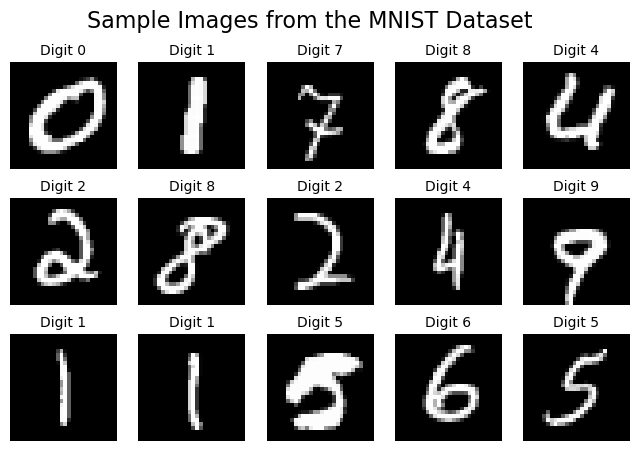

In [67]:
image_count = 15

plt.figure(figsize=(8, 5))
plt.suptitle('Sample Images from the MNIST Dataset', fontsize=16)

for i, (images, label) in enumerate(train_loader):
  for j in range(image_count):
    plt.subplot(3, 5, j + 1)
    plt.imshow(images[j].squeeze(), cmap='gray')
    plt.title(f"Digit {label[j].item()}", fontsize=10)
    plt.axis('off')
  break
plt.show()

# Neural network architecture design

Define an MLP model with two hidden layers and dropout regularization

In [68]:
class MLP(nn.Module):
    def __init__(self, num_features, num_hidden_1, num_hidden_2, num_classes):
        super().__init__()

        self.network = torch.nn.Sequential(
            # 1st hidden layer
            torch.nn.Flatten(),
            torch.nn.Linear(num_features, num_hidden_1),
            torch.nn.BatchNorm1d(num_hidden_1),
            torch.nn.ReLU(),
            torch.nn.Dropout(0.5),
            # 2nd hidden layer
            torch.nn.Linear(num_hidden_1, num_hidden_2),
            torch.nn.BatchNorm1d(num_hidden_2),
            torch.nn.ReLU(),
            torch.nn.Dropout(0.3),
            # output layer
            torch.nn.Linear(num_hidden_2, num_classes)
        )

    def forward(self, x):
        logits = self.network(x)
        return logits

Initialize Model

In [69]:
model = MLP(num_features=28*28,
            num_hidden_1=128,
            num_hidden_2=64,
            num_classes=10)

model = model.to(DEVICE)
criterion = nn.CrossEntropyLoss()


Configure various optimizers to experiment on

In [70]:
# Optimizer with Stochastich Gradient Descent
optimizer_sgd = torch.optim.SGD(model.parameters(),
                            lr=0.1,
                            momentum=0.9,
                            weight_decay=0.0001)

# Optimizer using Adam Moment Estimation
optimizer_adam = optim.Adam(model.parameters(), lr=0.001)

# Optimizer using Adaptive Gradient Algorithm
optimizer_adagrad = optim.Adagrad(model.parameters(), lr=0.01)

optimizers = [optimizer_sgd, optimizer_adam, optimizer_adagrad]

Create various learning rate schedulers o experiment on

In [71]:
def create_scheduler(optimizer, scheduler, desc):
    return {
        "optimizer": optimizer,
        "scheduler": scheduler,
        "desc": desc
    }

In [72]:
training_params = []

for optimizer in optimizers:
    optimizer_desc = f'{optimizer.__class__.__name__} optimizer with'

    desc = f'{optimizer_desc} Validation loss plateau scheduler' 
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer_sgd, factor=0.1, mode='min')
    training_params.append(create_scheduler(optimizer, scheduler, desc))

    desc = f'{optimizer_desc} Step decay scheduler' 
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=30, gamma=0.1)
    training_params.append(create_scheduler(optimizer, scheduler, desc))

    desc = f'{optimizer_desc} Exponential decay scheduler' 
    scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer_sgd, gamma=0.95)
    training_params.append(create_scheduler(optimizer, scheduler, desc))

print(f'Running {len(training_params)} experiments:')
for param in training_params:
    print(param['desc'])


Running 9 experiments:
SGD optimizer with Validation loss plateau scheduler
SGD optimizer with Step decay scheduler
SGD optimizer with Exponential decay scheduler
Adam optimizer with Validation loss plateau scheduler
Adam optimizer with Step decay scheduler
Adam optimizer with Exponential decay scheduler
Adagrad optimizer with Validation loss plateau scheduler
Adagrad optimizer with Step decay scheduler
Adagrad optimizer with Exponential decay scheduler


# Training and Testing

Utility function to calculate the mode accuracy

In [73]:
def compute_accuracy(data_loader):
    with torch.no_grad():
        correct_pred, num_examples = 0, 0
        for i, (features, targets) in enumerate(data_loader):
            features = features.to(DEVICE)
            targets = targets.float().to(DEVICE)
            logits = model(features)
            _, predicted_labels = torch.max(logits, 1)
            num_examples += targets.size(0)
            correct_pred += (predicted_labels == targets).sum()
    return correct_pred.float()/num_examples * 100

Create the training and testing function

In [74]:
def train(epochs, optimizer, scheduler):
    start_time = time.time()

    minibatch_loss_list, train_acc_list, valid_acc_list = [], [], []
    elapsed = 0
    test_acc = None
    
    for epoch in range(epochs):
        model.train()

        for batch_idx, (features, targets) in enumerate(train_loader):
            features = features.to(DEVICE)
            targets = targets.to(DEVICE)

            # FORWARD AND BACK PROP
            logits = model(features)

            # loss = F.cross_entropy(logits, targets)
            optimizer.zero_grad()
            loss = criterion(logits, targets)
            optimizer.zero_grad()

            loss.backward()

            # UPDATE MODEL PARAMETERS
            optimizer.step()

            # LOGGING
            minibatch_loss_list.append(loss.item())
            logging_interval = 100

            if not batch_idx % logging_interval:
                print("Epoch: ", epoch+1, "/", NUM_EPOCHS,
                      "| Batch ", batch_idx,
                      "/", len(train_loader),
                      f'| Loss: {loss:.4f}')

        model.eval()

        with torch.no_grad():  # save memory during inference
            train_acc = compute_accuracy(train_loader)
            valid_acc = compute_accuracy(valid_loader)
            print("Epoch: ", epoch+1, "/", NUM_EPOCHS,
                  f'| Train: {train_acc :.2f}% '
                  f'| Validation: {valid_acc :.2f}%')

            train_acc_list.append(train_acc.item())
            valid_acc_list.append(valid_acc.item())

        elapsed = (time.time() - start_time) / 60
        print("Time elapsed: ", elapsed, " min")
        scheduler.step(minibatch_loss_list[-1])

    elapsed = (time.time() - start_time) / 60
    print(f'Total Training Time: {elapsed:.2f} min')

    test_acc = compute_accuracy(test_loader)
    print(f'Test accuracy {test_acc :.2f}%')

    print('-----------------------------')

    return {'elapsed': elapsed,
            'test_acc': test_acc,
            'minibatch_loss_list': minibatch_loss_list,
            'train_acc_list': train_acc_list,
            'valid_acc_list': valid_acc_list}

Start the training

In [75]:
NUM_EPOCHS = 20

training_results = []
for params in training_params:

    print('=============================')
    print(params['desc'])
    print('=============================')

    results = train(NUM_EPOCHS, params['optimizer'], params['scheduler'])
    
    results['desc'] = params['desc']
    training_results.append(results)

SGD optimizer with Validation loss plateau scheduler
Epoch:  1 / 20 | Batch  0 / 843 | Loss: 2.4509


Epoch:  1 / 20 | Batch  100 / 843 | Loss: 0.5046
Epoch:  1 / 20 | Batch  200 / 843 | Loss: 0.3790
Epoch:  1 / 20 | Batch  300 / 843 | Loss: 0.2661
Epoch:  1 / 20 | Batch  400 / 843 | Loss: 0.5019
Epoch:  1 / 20 | Batch  500 / 843 | Loss: 0.4761
Epoch:  1 / 20 | Batch  600 / 843 | Loss: 0.3214
Epoch:  1 / 20 | Batch  700 / 843 | Loss: 0.5454
Epoch:  1 / 20 | Batch  800 / 843 | Loss: 0.1867
Epoch:  1 / 20 | Train: 95.57% | Validation: 96.73%
Time elapsed:  0.16249556541442872  min
Epoch:  2 / 20 | Batch  0 / 843 | Loss: 0.1271
Epoch:  2 / 20 | Batch  100 / 843 | Loss: 0.2757
Epoch:  2 / 20 | Batch  200 / 843 | Loss: 0.3276
Epoch:  2 / 20 | Batch  300 / 843 | Loss: 0.3837
Epoch:  2 / 20 | Batch  400 / 843 | Loss: 0.3748
Epoch:  2 / 20 | Batch  500 / 843 | Loss: 0.1676
Epoch:  2 / 20 | Batch  600 / 843 | Loss: 0.2278
Epoch:  2 / 20 | Batch  700 / 843 | Loss: 0.4808
Epoch:  2 / 20 | Batch  800 / 843 | Loss: 0.2684
Epoch:  2 / 20 | Train: 96.41% | Validation: 96.83%
Time elapsed:  0.32089418

Visualize the training progress

<Figure size 1200x1200 with 0 Axes>

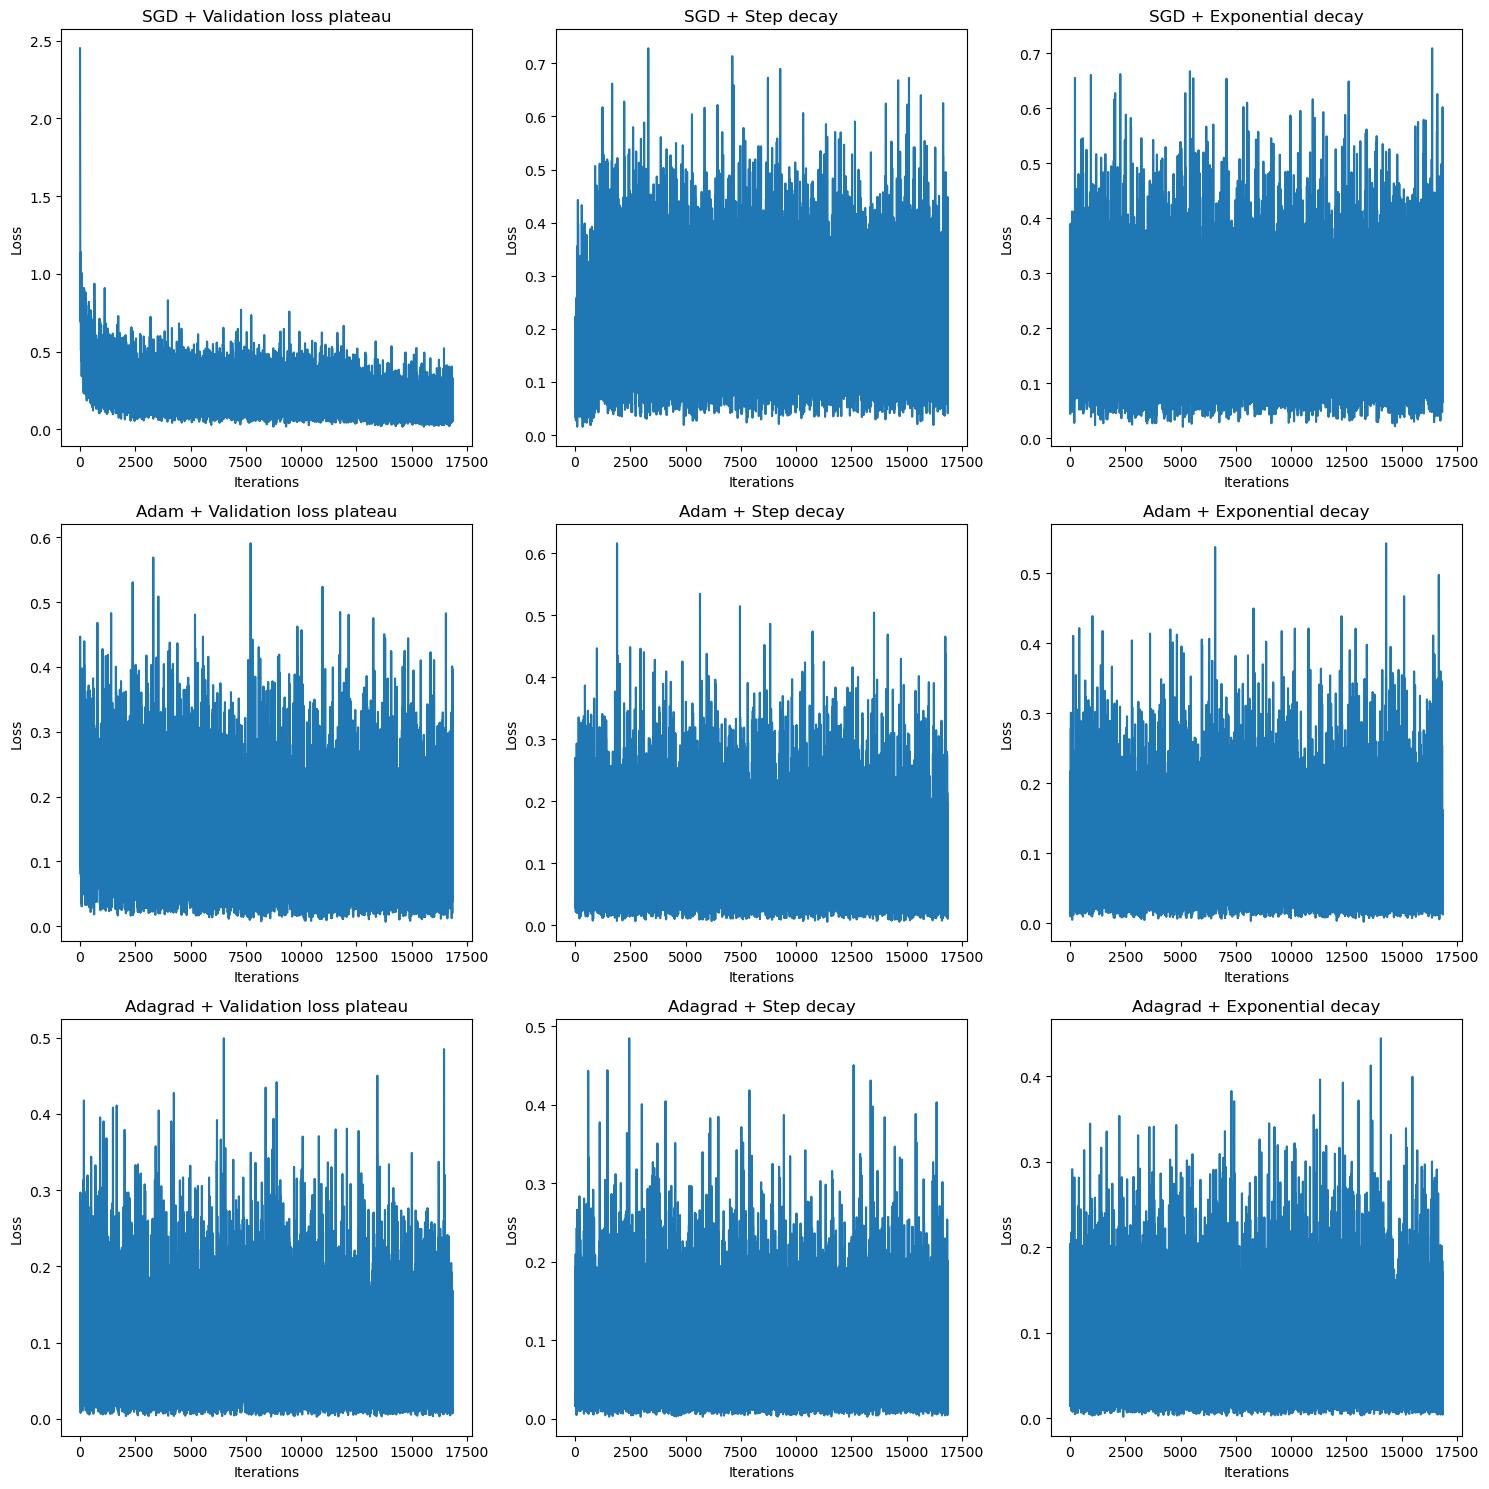

In [76]:
plt.figure(figsize=(12, 12))
fig, ax = plt.subplots(3, 3, figsize=(15, 15))

for i, results in enumerate(np.array(training_results).reshape((3,3))): 
    for j, res in enumerate(results): 
        loss_list = res['minibatch_loss_list']
        title = str(res['desc']).replace(' optimizer with ', ' + ').replace(' scheduler','')

        ax[i,j].plot(range(len(loss_list)), loss_list)
        ax[i,j].set_title(title)
        ax[i,j].set_xlabel('Iterations')
        ax[i,j].set_ylabel('Loss')

plt.tight_layout()
plt.show()

Compare the training and validation accuracies over epochs

<Figure size 1200x1200 with 0 Axes>

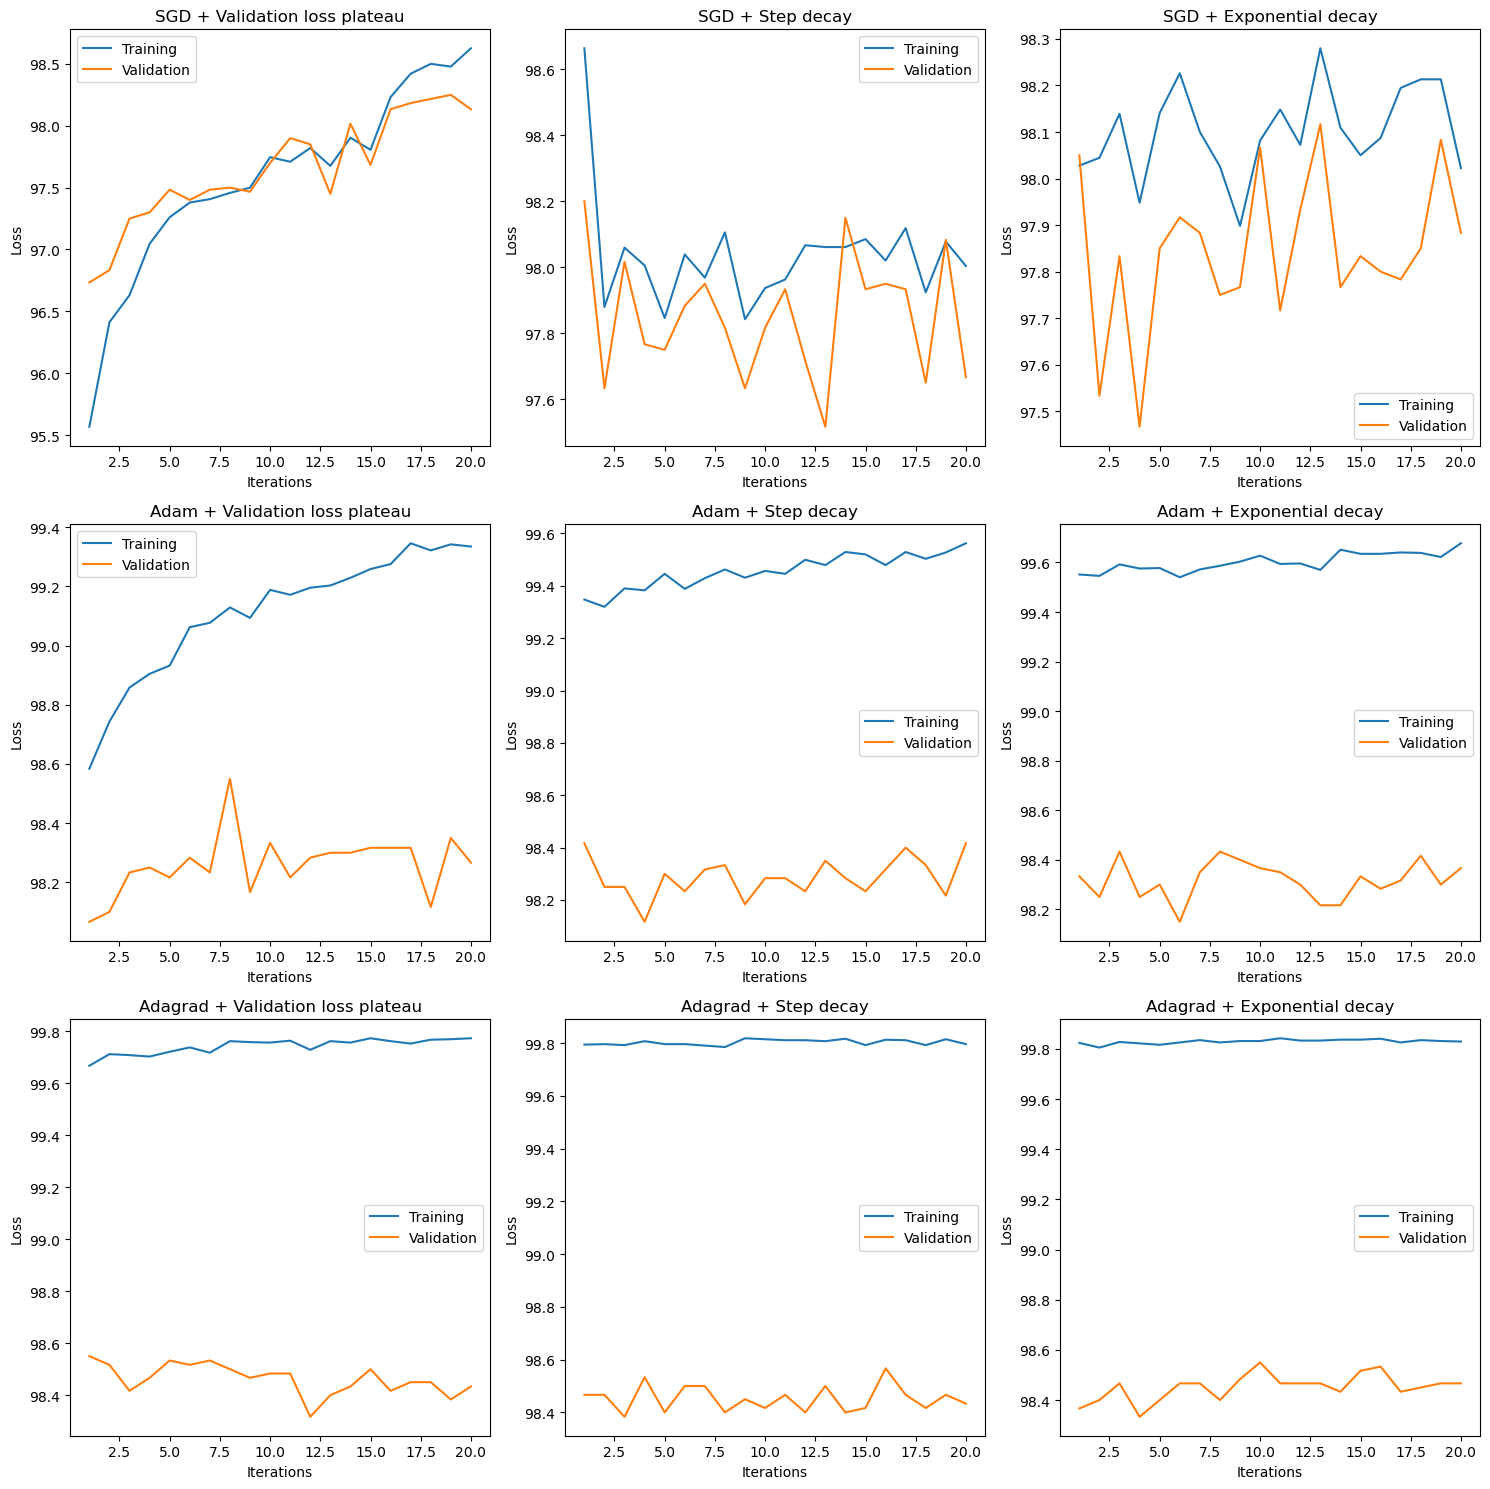

In [80]:
plt.figure(figsize=(12, 12))
fig, ax = plt.subplots(3, 3, figsize=(15, 15))

for i, results in enumerate(np.array(training_results).reshape((3,3))): 
    for j, res in enumerate(results): 
        train_acc_list = res['train_acc_list']
        valid_acc_list = res['valid_acc_list']
        num_epochs = len(train_acc_list)
        title = str(res['desc']).replace(' optimizer with ', ' + ').replace(' scheduler','')

        ax[i,j].plot(np.arange(1, num_epochs+1), train_acc_list, label='Training')
        ax[i,j].plot(np.arange(1, num_epochs+1), valid_acc_list, label='Validation')
        ax[i,j].set_title(title)
        ax[i,j].set_xlabel('Iterations')
        ax[i,j].set_ylabel('Loss')
        ax[i,j].legend()

plt.tight_layout()
plt.show()